In [1]:
#Importing relevant libraries
from pdfminer.high_level import extract_text
import PyPDF2
from PyPDF2 import PdfReader
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import download
from gensim import corpora, models
from gensim.models import CoherenceModel
import os
import statistics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tensorflow as tf
import os
import pdfplumber
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from gensim.corpora import Dictionary
from gensim.models import HdpModel



# Download other resources
download('stopwords')
download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cdlacey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cdlacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#Initial stats - file count

def count_files_in_folder(folder_path):
    # Initialize a counter for files
    file_count = 0

    # Walk through the directory and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample'
total_files = count_files_in_folder(folder_path)
print("Total files in datasource: ", total_files)

Total files in datasource:  25


In [3]:
#Initial stats - page count

def count_pages_and_stats(folder_path):
    total_pages = 0
    page_counts = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                num_pages = len(pdf_reader.pages)
                total_pages += num_pages
                page_counts.append(num_pages)

    mean_page_count = statistics.mean(page_counts)
    median_page_count = statistics.median(page_counts)

    return total_pages, mean_page_count, median_page_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample'
total_pages, mean_page_count, median_page_count = count_pages_and_stats(folder_path)

print("Total pages in all PDF files:", total_pages)
print("Mean page count per file:", mean_page_count)
print("Median page count per file:", median_page_count)

Total pages in all PDF files: 2113
Mean page count per file: 84.52
Median page count per file: 82


In [4]:
# Function for preprocessing text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    french_stopwords = set(stopwords.words('french'))
    stop_words.update(french_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    # Remove numbers, symbols, and certain words
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    # Remove specific words or letters which are not useful
    additional_stopwords = {
        'mr.', 'mr', 'mrs.', 'ms.', 'speaker', 'bill', 'debate', 'hon', 'cpc', 'lib', 'bq', 'canadian', 
        'act', 'amend', 'amendment', 'canada', 'house', 'public', 'honour', 'minister', 'ministry', 'govern', 
        'member', 'program', 'primeminister', 'would', 'people', 'chair', 'committe', 'liber', 'polici', 'parliamentari', 
        'ndp', 'government', 'conserv', 'parties', 'partisan', 's', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'am', 'pm','year','time','motion','go', 'canadians', 
        'also', 'members', 'madam', 'committee', 'prime', 'senate', 'senator', 'hous',
        'one', 'govern', 'liberal', 'conservative', 'liberals', 'conservatives', 'speech', 'parliamentarian',
        'secretariat', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', '000', '1', '3', '5', '11', 
        '15', '22', '25', '2007', '2008', '2009', '2010', '2011',
        '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '‚Äô',
        '‚Äú', '‚Äù', "’",'...................',' ................................................',
        '........',"'s"}
    tokens = [token for token in tokens if token not in additional_stopwords]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Directory path containing PDF files
pdf_directory = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample'

# List all PDF files in the directory
pdf_files = [os.path.join(pdf_directory, file) for file in os.listdir(pdf_directory) if file.endswith('.pdf')]

texts = []

# Loop through each PDF file and extract text
for pdf_file in pdf_files:
    with pdfplumber.open(pdf_file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
        texts.append(text)

# Preprocess text
preprocessed_texts = [preprocess_text(text) for text in texts]

# Create a dictionary from the preprocessed text
dictionary = Dictionary(preprocessed_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


In [5]:
#spliting data for cross validation
from sklearn.model_selection import train_test_split

train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

In [6]:
# Train the HDP model
hdp_model = HdpModel(train_corpus, id2word=dictionary)

In [7]:
#First evaluation of HDP model and number of topics identified per document)
rows = []

# Iterate through each document in the corpus
for i, doc in enumerate(corpus):
    doc_topics = hdp_model[doc]
    # Extract topic numbers and their probabilities
    topic_numbers = [topic[0] for topic in doc_topics]
    topic_probs = [topic[1] for topic in doc_topics]
    # Append the document's topics to the rows list
    rows.append([i, topic_numbers, topic_probs])

# Create a DataFrame from the list of rows
doc_topics_df = pd.DataFrame(rows, columns=['Document_Index', 'Topic_Numbers', 'Topic_Probabilities'])

# Display the DataFrame
doc_topics_df.head(10)

,Document_Index,Topic_Numbers,Topic_Probabilities
0,0,"[0, 2, 3, 7, 8, 9, 10, 16, 30, 35, 64, 96, 136...","[0.23419833177398008, 0.02400255469847168, 0.0..."
1,1,[10],[0.9958126425205597]
2,2,[0],[0.9999337075357678]
3,3,[0],[0.9999660453292784]
4,4,[1],[0.9999824361665932]
5,5,[5],[0.9999407967062572]
6,6,[4],[0.9999472789142305]
7,7,[7],[0.9999372293779001]
8,8,"[0, 2, 3, 4, 5, 10, 18, 58, 87, 130]","[0.10242118140408038, 0.19703977961701313, 0.3..."
9,9,[9],[0.999931839562549]


In [8]:
# To find an approximate number of total topics identified within the HDP model, I found it easiest to train an
#LDA model on the HDP model. 
# Here we'll train an LDA model using the HDP model as a training mechanism
lda_model_t = hdp_model.suggested_lda_model()

# Get the topic distributions for each document
doc_topics = [lda_model_t.get_document_topics(doc) for doc in corpus]

# Count the number of unique topics
unique_topics = set()
for doc_topics in doc_topics:
    unique_topics.update([topic[0] for topic in doc_topics])

num_topics_identified = len(unique_topics)
print(f"Number of topics identified by HDP model: {num_topics_identified}")


Number of topics identified by HDP model: 18


In [9]:
#From the Literature Review, the ideal topics for LDA was found to be 7. 
from gensim.models import LdaModel

# Train the LDA model
lda_model = LdaModel(train_corpus, id2word=dictionary, num_topics=7, update_every=1, chunksize=10, passes=10)

In [10]:
#Avoiding diving by 0
import numpy as np

# Example coherence calculation
def calculate_coherence(cv1, cv2):
    try:
        # Check for division by zero
        if np.sum(cv1) == 0 or np.sum(cv2) == 0:
            return 0.0
        
        # Calculate coherence
        coherence = cv1.T.dot(cv2)[0, 0] / (np.sqrt(np.sum(cv1) * np.sum(cv2)))
        
        # Check for NaN or Inf values
        if np.isnan(coherence) or np.isinf(coherence):
            return 0.0
        
        return coherence
    except Exception as e:
        print(f"Error in coherence calculation: {e}")
        return 0.0

# Example usage
cv1 = np.array([1, 2, 3])
cv2 = np.array([4, 5, 6])
coherence_value = calculate_coherence(cv1, cv2)
print("Coherence:", coherence_value)

# Evaluate LDA & HDP model on the testing set
from gensim.models import CoherenceModel

def evaluate_model(model, corpus, dictionary):
    coherence_model = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# Assuming lda_model and hdp_model are already trained
lda_coherence = evaluate_model(lda_model, test_corpus, dictionary)
hdp_coherence = evaluate_model(hdp_model, test_corpus, dictionary)

print("LDA Coherence:", lda_coherence)
print("HDP Coherence:", hdp_coherence)

Error in coherence calculation: invalid index to scalar variable.
Coherence: 0.0


/Users/cdlacey/anaconda3/lib/python3.11/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/Users/cdlacey/anaconda3/lib/python3.11/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


LDA Coherence: nan
HDP Coherence: nan


In [11]:
#Evaluating LDA topic coherance values. 
from gensim.models import CoherenceModel

# Calculate coherence values for each topic
coherence_values = {}
for topic_num in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_num)
    topic_words = [term for term, _ in topic_terms]
    coherence_model = CoherenceModel(topics=[topic_words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.41170142582308006
1	0.4059161478055757
2	0.5498209228613706
3	0.33592391639674657
4	0.44499390393819216
5	0.3340273127242817
6	0.31009605800402007


In [12]:
# Finding the overall LDA model coherance value
topics = lda_model.show_topics(num_topics=-1, formatted=False)

# Calculate coherence values for each topic
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print("Coherence Score for LDA model:", coherence_lda)

Coherence Score for LDA model: 0.38331608119518


In [13]:
#Evaluating HDP topic coherance values, which were found to have a range below as well as above the LDA model
from gensim.models import CoherenceModel

hdp_topics = hdp_model.show_topics(num_topics=15, formatted=False)  # Get the top 15 topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.40321043189655903
1	0.5815620435360508
2	0.40197169749121836
3	0.3708798646140238
4	0.35631095661923473
5	0.4597742834083295
6	0.40607332438045696
7	0.2992906307515513
8	0.2455296730344886
9	0.4200206196641586
10	0.2603264167910506
11	0.43000834546330263
12	0.7229035415121664
13	0.7534782347047365
14	0.7177906262180498


In [14]:
# Finding the overall coherhance value for HDP model
hdp_topics = hdp_model.show_topics(num_topics=15, formatted=False)  # Get the top 15 topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Compute the average coherence value
avg_coherence_value = sum(coherence_values.values()) / len(coherence_values)

print("Overall Coherence Value for HDP model:", avg_coherence_value)

Overall Coherence Value for HDP model: 0.4552753793390252


In [24]:
#Generate df with dominant topics, the topic contribution and topic keywords for LDA model
import pandas as pd

def format_topics(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df


df_topic_keywords = format_topics(ldamodel=lda_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,4,0.5215,"right, work, want, need, make, know, order, like, issu, question","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
1,4,0.6244,"right, work, want, need, make, know, order, like, issu, question","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, decemb, h..."
2,4,0.9999,"right, work, want, need, make, know, order, like, issu, question","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
3,4,1.0000,"right, work, want, need, make, know, order, like, issu, question","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, novemb, h..."
4,2,0.9947,"tax, carbon, yea, commonsdeb, agre, mass, nay, sidhu, brison, fraser","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
5,5,0.6184,"ontario, qubec, trade, agreement, parliamentari, right, elect, commonsdeb, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, march, hono..."
6,4,1.0000,"right, work, want, need, make, know, order, like, issu, question","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
7,5,0.9993,"ontario, qubec, trade, agreement, parliamentari, right, elect, commonsdeb, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, januari, ho..."
8,4,0.9299,"right, work, want, need, make, know, order, like, issu, question","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, octob, ho..."
9,4,0.9999,"right, work, want, need, make, know, order, like, issu, question","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."


In [25]:
#Generate df of represtative text for dominant topics for LDA model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format DF
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,2,0.9947,"tax, carbon, yea, commonsdeb, agre, mass, nay, sidhu, brison, fraser","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
1,4,1.0000,"right, work, want, need, make, know, order, like, issu, question","[parliament, session, common, debat, offici, report, hansard, volum, monday, april, honour, anth..."
2,5,0.9999,"ontario, qubec, trade, agreement, parliamentari, right, elect, commonsdeb, countri, english","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."


In [28]:
#Generate df with dominant topics, the topic contribution and topic keywords for HDP model
import pandas as pd

def topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, topics in enumerate(ldamodel[corpus]):
        # Sort topics by contribution
        topics = sorted(topics, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(topics):
            if j == 0:  # Dominant topic
                topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df

df_topic_keywords = format_topics_sentences(ldamodel=hdp_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,10,0.2977,"elect, ontario, qubec, offic, elector, vote, parliamentari, make, chief, voter, young, britishco...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
1,10,0.9958,"elect, ontario, qubec, offic, elector, vote, parliamentari, make, chief, voter, young, britishco...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, decemb, h..."
2,0,0.9999,"right, work, want, make, need, issu, know, import, commun, like, order, legisl, support, us, say...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
3,0,1.0000,"right, work, want, make, need, issu, know, import, commun, like, order, legisl, support, us, say...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, novemb, h..."
4,1,1.0000,"tax, carbon, yea, agre, commonsdeb, mass, nay, brison, sidhu, fraser, mcleod, casey, board, trea...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
5,5,0.9999,"trade, agreement, hondura, countri, free, right, human, econom, export, hors, commonsdeb, work, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, march, hono..."
6,4,0.9999,"inform, crime, countri, legisl, want, victim, commonsdeb, need, state, order, work, say, prison,...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
7,7,0.9999,"counterfeit, ontario, qubec, parliamentari, good, right, new, border, import, industri, resourc,...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, januari, ho..."
8,3,0.3347,"first, nation, commun, right, work, develop, make, commonsdeb, women, want, issu, support, legis...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, octob, ho..."
9,9,0.9999,"nuclear, energi, liabil, order, industri, commonsdeb, tax, million, know, say, want, colleagu, p...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."


In [30]:
#Generate df of represtative text for dominant topics for HDP model
import pandas as pd

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,1.0000,"right, work, want, make, need, issu, know, import, commun, like, order, legisl, support, us, say...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, novemb, h..."
1,1,1.0000,"tax, carbon, yea, agre, commonsdeb, mass, nay, brison, sidhu, fraser, mcleod, casey, board, trea...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
2,2,1.0000,"need, tax, want, make, work, know, get, go, talk, health, plan, like, see, support, mani, countr...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, novemb, hon..."
3,3,1.0000,"first, nation, commun, right, work, develop, make, commonsdeb, women, want, issu, support, legis...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, may, hono..."
4,4,0.9999,"inform, crime, countri, legisl, want, victim, commonsdeb, need, state, order, work, say, prison,...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
5,5,0.9999,"trade, agreement, hondura, countri, free, right, human, econom, export, hors, commonsdeb, work, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, march, hono..."
6,6,0.9999,"privileg, question, parliament, want, opposit, import, work, chang, place, stand, parliamentari,...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, may, honou..."
7,7,0.9999,"counterfeit, ontario, qubec, parliamentari, good, right, new, border, import, industri, resourc,...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, januari, ho..."
8,8,0.9999,"ontario, qubec, resourc, commun, crime, support, parliamentari, develop, project, first, childre...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, novemb, hon..."
9,9,0.9999,"nuclear, energi, liabil, order, industri, commonsdeb, tax, million, know, say, want, colleagu, p...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."


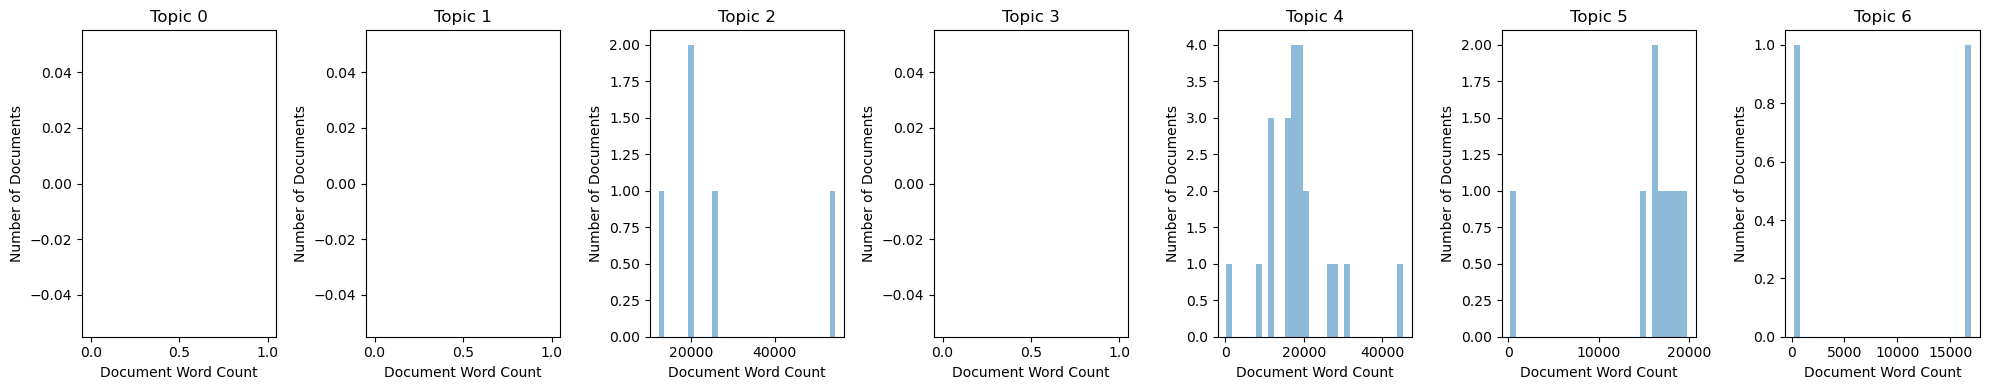

In [19]:
#Ploting document word count against nubmer of documents for LDA model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 4))

for i in range(7):
    word_counts = []

    
    for doc in corpus:
        # Get the topic distribution for the document
        doc_topics = lda_model.get_document_topics(doc)

        # Check if the current topic is the dominant topic for the document
        for topic, prob in doc_topics:
            if topic == i:
                # Calculate the word count of the document and add it to the list
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    axes[i].hist(word_counts, bins=30, alpha=0.5)
    axes[i].set_title(f'Topic {i}')
    axes[i].set_xlabel('Document Word Count')
    axes[i].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

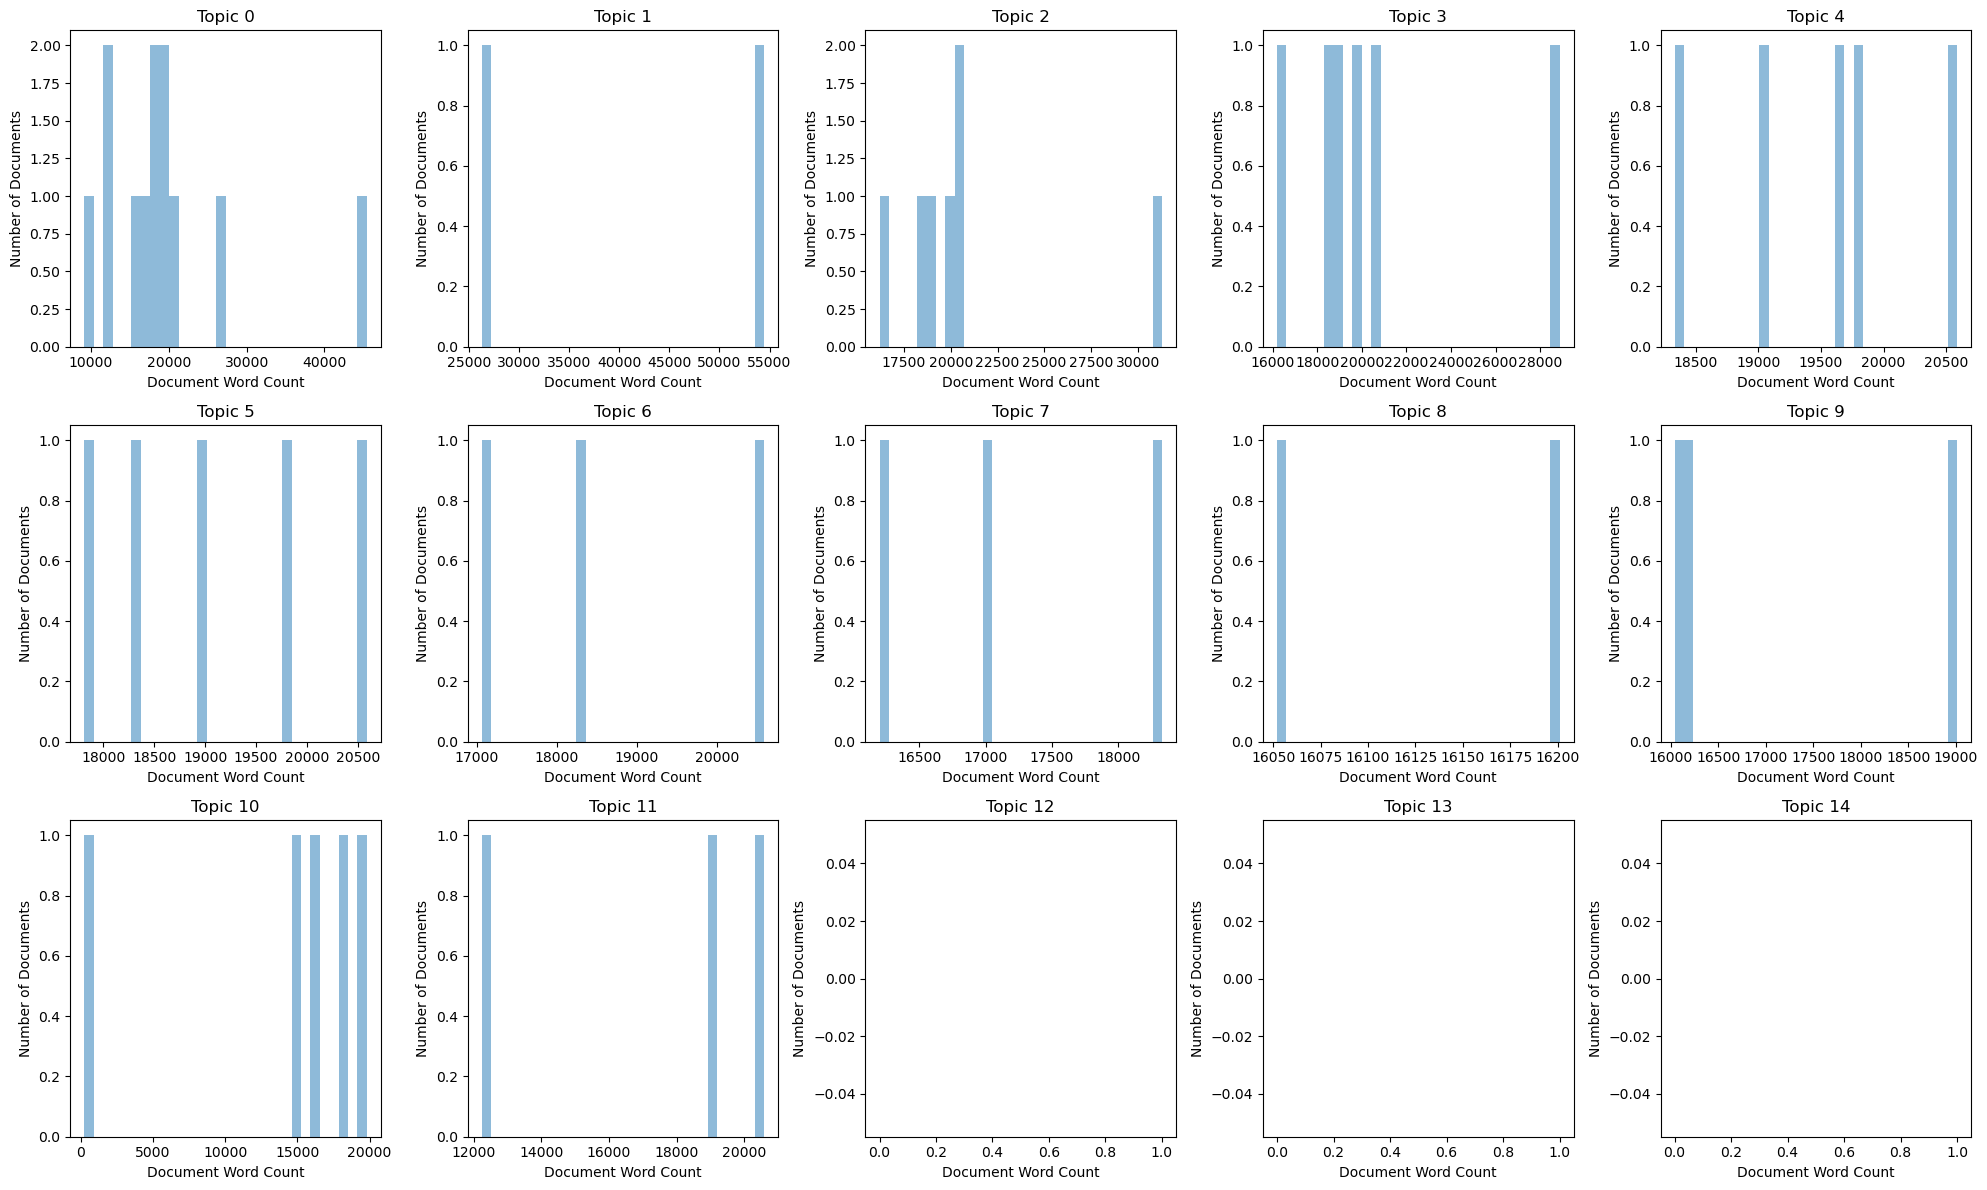

In [31]:
#Ploting document word count against nubmer of documents for HDP model
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))


for i in range(15):
    word_counts = []

    for doc in corpus:
        doc_topics = hdp_model[doc]

        for topic, prob in doc_topics:
            if topic == i:
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    # Determine the position of the subplot in the grid
    row_index = i // 5
    col_index = i % 5

    axes[row_index, col_index].hist(word_counts, bins=30, alpha=0.5)
    axes[row_index, col_index].set_title(f'Topic {i}')
    axes[row_index, col_index].set_xlabel('Document Word Count')
    axes[row_index, col_index].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

In [21]:
#Exploring the relevant terms for each topic of the LDA Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.237107 -0.009765       1        1  72.451815
5     -0.167034 -0.134118       2        1  14.009013
2     -0.145132  0.157310       3        1  12.645689
6      0.155457 -0.005134       4        1   0.891210
3      0.131188 -0.002679       5        1   0.000758
0      0.131232 -0.002815       6        1   0.000758
1      0.131396 -0.002799       7        1   0.000758, topic_info=         Term        Freq        Total Category  logprob  loglift
3080   offici  388.000000   388.000000  Default  30.0000  30.0000
2500  languag  234.000000   234.000000  Default  29.0000  29.0000
3191  ontario  645.000000   645.000000  Default  28.0000  28.0000
4256      tax  909.000000   909.000000  Default  27.0000  27.0000
127       air  146.000000   146.000000  Default  26.0000  26.0000
...       ...         ...          ...      ...      ...      ...
998   concern    0.000046   680.422200   Topic7 -11.3228  -4.7241
2096   import    0.000046  1213.963971   Topic7 -11.3230  -5.3032
4209  support    0.000046  1222.952070   Topic7 -11.3231  -5.3107
114      agre    0.000046   723.867301   Topic7 -11.3231  -4.7864
3557  protect    0.000046   688.357133   Topic7 -11.3235  -4.7364

[506 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
46661      4  0.711385     ace
5414       1  0.513629  acquir
5414       2  0.085605  acquir
5414       3  0.256815  acquir
5414       4  0.085605  acquir
...      ...       ...     ...
5193       2  0.039651    year
5193       3  0.046081    year
5208       1  0.621242   young
5208       2  0.325807   young
5208       3  0.055222   young

[570 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 3, 7, 4, 1, 2])

In [32]:
#Exploring the relevant terms for each topic of the HDP Model
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(hdp_model, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster          Freq
topic                                                   
0     -0.401928  0.056607       1        1  3.158155e+01
2     -0.450111  0.076233       2        1  1.451960e+01
1     -0.399982  0.101665       3        1  1.135611e+01
3     -0.388155  0.058317       4        1  7.436133e+00
4     -0.374003  0.049143       5        1  4.710208e+00
...         ...       ...     ...      ...           ...
39     0.032654  0.000447     146        1  6.067335e-14
41     0.032628  0.000064     147        1  1.516834e-14
42     0.032989 -0.000464     148        1  7.584169e-15
48     0.032947  0.000506     149        1  1.185026e-16
83     0.033199  0.000568     150        1  3.448881e-27

[150 rows x 5 columns], topic_info=                                                        Term          Freq  \
116                                                agreement  5.500000e+02   
4723                                                   trade  5.740000e+02   
3191                                                 ontario  6.280000e+02   
5342                                                privileg  3.690000e+02   
3792                                                   right  1.722000e+03   
...                                                      ...           ...   
73186  havetheunanimousconsentofthehousetosplithistimewithth  9.103972e-28   
3728                                                   renov  1.015238e-27   
8377                                                andallow  9.471431e-28   
62986                      havedonethisonotherpiecesoflegisl  9.133526e-28   
1450                                             environment  9.728728e-28   

             Total  Category  logprob  loglift  
116     550.000000   Default  30.0000  30.0000  
4723    574.000000   Default  29.0000  29.0000  
3191    628.000000   Default  28.0000  28.0000  
5342    369.000000   Default  27.0000  27.0000  
3792   1722.000000   Default  26.0000  26.0000  
...            ...       ...      ...      ...  
73186     1.578456  Topic150  -9.8481   2.8168  
3728     18.806951  Topic150  -9.7391   0.4480  
8377      3.753268  Topic150  -9.8086   1.9902  
62986     1.750083  Topic150  -9.8449   2.7168  
1450    212.558037  Topic150  -9.7818  -2.0196  

[9179 rows x 6 columns], token_table=       Topic      Freq                                                   Term
term                                                                         
50109     11  0.811878                                                     aa
5387       1  0.745297                                                abalanc
5393       1  0.622386                           abandoningtheworkersinoshawa
24500      5  0.785059                                          abdulmutallab
46637      1  0.609757  abidingcitizenswhoarefrustratedattimeswhentheyseesent
...      ...       ...                                                    ...
5212      12  0.251217                                                  youth
13239      1  0.597243                     youwouldfindconsentamongallthememb
8197       1  0.635655                                     youwouldfindunanim
29046      5  0.732099                                                zamboni
56974      1  0.610401                                           zeroatsecond

[8697 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5, 6, 11, 7, 8, 10, 9, 12, 31, 70, 137, 78, 89, 102, 109, 17, 19, 65, 81, 75, 97, 149, 88, 148, 120, 36, 106, 141, 23, 71, 127, 30, 131, 138, 114, 68, 98, 55, 21, 59, 126, 128, 103, 121, 37, 96, 144, 66, 32, 57, 62, 25, 38, 122, 52, 133, 112, 50, 124, 107, 44, 28, 39, 41, 72, 53, 130, 147, 56, 93, 129, 48, 80, 136, 134, 85, 54, 67, 108, 118, 29, 111, 91, 145, 47, 33, 34, 117, 87, 16, 58, 14, 15, 95, 86, 146, 90, 116, 69, 46, 99, 63, 113, 77, 76, 139, 27, 24, 119, 83, 13, 132, 105, 143, 22, 82,